### Project Part III

In this part of project, we are going to apply our machine learning techniques to solve our third problem: **Do streaming platforms show specific preferences in the genres of movies they make available?**

In [1]:

import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier, 
    VotingClassifier,
)
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import (
    auc,
    confusion_matrix,
    accuracy_score, 
    classification_report,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedShuffleSplit



## Preprocessing Data

In [2]:
# import datasets
imdb = pd.read_csv("./data/imdb_movies.csv")
amazon = pd.read_csv("./data/amazon_prime_titles.csv")
disney = pd.read_csv("./data/disney_plus_titles.csv")
netflix = pd.read_csv("./data/netflix_titles.csv")
amazon['app'] = 'Amazon'
disney['app'] = 'Disney'
netflix['app'] = 'Netflix'
apps = pd.concat([amazon,disney,netflix],axis='rows',ignore_index=True)
apps = apps[apps['type'] == 'Movie']
df = imdb.merge(apps, left_on='names', right_on='title', how='left')

In [3]:
df.drop(columns=['country_y','release_year','status','type','title'], inplace=True)
df.rename(columns={'names':'titles','country_x':'country', 'date_x': 'date', 
                    'budget_x': 'budget', 'duration':'duration(min)'}, inplace=True)

# fill missing value for rating column
df['rating'] = df['rating'].fillna('Not Rated')

# clean duration column
df['duration(min)'] = df['duration(min)'].str.replace(' min','').astype('Int64')

# divide data into 5-year groups
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['year_group'] = ((df['year'] - 1) // 5) * 5  + 1
# create labels like "2001-2005", "2006-2010", etc.
df['year_group_label'] = df['year_group'].astype(str) + '-' + (df['year_group'] + 4).astype(str)

In [4]:
# create genres dummy variables
# Split genres and combine into one list without duplicates
all_genres = df['genre'].dropna().str.split(',').explode().str.strip().unique()
genre_df = df[['titles','genre']].copy()
for genre in all_genres:
    genre_df.loc[genre_df["genre"].str.contains(genre, na=False), genre] = 1
    genre_df[genre] = genre_df[genre].fillna(0) 
df = df.merge(genre_df, on=['titles','genre'], how='left')

Now, we have successfully preprocessed our data. We have imported the datasets, cleaned our data, and handled missing values. Since we want to figure out whether genres are factors for predicting the streaming platforms's preferences for movies, we will only keep the rows that contain the data of **app** in the DataFrame. 

In [5]:
# drop the rows with missing labels
df_full = df.dropna(subset=['app'], axis=0)
df_full.shape

(3238, 42)

we can observe that after dropping the rows with missing labels, there are still 3238 rows left in our new dataset. Then, we want to recheck if there is any missing data under the features we are interested in.

In [6]:
selected_features = ["score", "duration(min)", "budget", "revenue", 
                        "rating", "year_group", "country"] + list(all_genres)

In [7]:
df_full[selected_features].isna().sum()

score              0
duration(min)      0
budget             0
revenue            0
rating             0
year_group         0
country            0
Drama              0
Action             0
Science Fiction    0
Adventure          0
Animation          0
Family             0
Fantasy            0
Comedy             0
Thriller           0
Crime              0
Horror             0
Mystery            0
History            0
War                0
Documentary        0
Romance            0
Music              0
Western            0
TV Movie           0
dtype: int64

We can observe that there is no missing data in any feature column, so we will continue with this dataset and split the data.

In [8]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(["app"], axis=1),
    df_full["app"],
    test_size=0.2,
    random_state=42,
)

### Dimensionality Reduction

In [9]:
num_columns = ["score", "budget", "revenue", "duration(min)"]
cat_columns = ["country", "rating", "year_group"]

In [10]:
num_pipeline = Pipeline(
    [("impute", SimpleImputer(strategy="median")), 
        ("scale", StandardScaler())]
)

pca_preprocessing_pipeline = ColumnTransformer(
    [   ("numeric", num_pipeline, num_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_columns), 
        ('genres', 'passthrough', all_genres)
    ],remainder='drop')


In [11]:
X_prep = pca_preprocessing_pipeline.fit_transform(X_train)

In [12]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_prep)

In [13]:
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "app": y_train.reset_index(drop=True)
})

In [14]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.21123367 0.15878823 0.10447669 0.06205249]
Total variance explained: 0.536551067573261


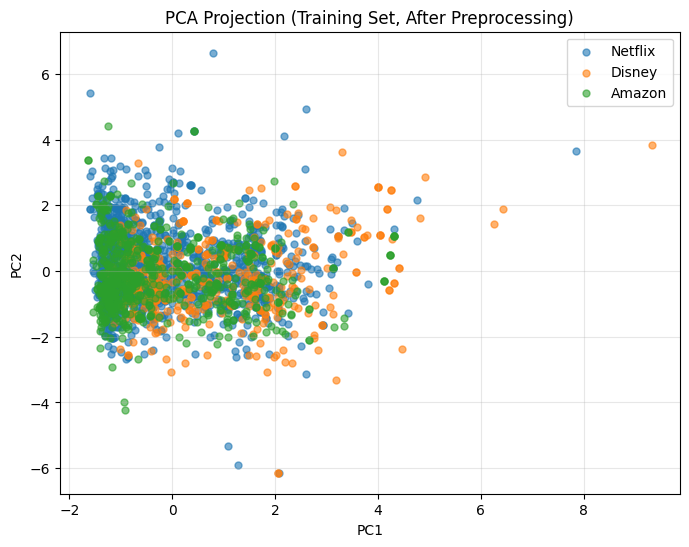

In [15]:
plt.figure(figsize=(8,6))
for label in pca_df["app"].unique():
    subset = pca_df[pca_df["app"] == label]
    plt.scatter(subset["PC1"], subset["PC2"], alpha=0.6, label=label, s=25)

plt.title("PCA Projection (Training Set, After Preprocessing)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

We have applied Principal Component Analysis as our dimensionality reduction techniques to the preprocessed feature matrix, and projected into a 2-dimensional spaces with PC1 and PC2, which explains 21.12% and 15.88% of the variance respectively. With the scatter plot above, we can find that movies available in different streaming platforms overlap in this dimensionality reduced space, indicating that this platform preference cannot be easily separated using linear combinations of the features. 

In other words, the platform labels do not form distinct clusters in this reduced dimensional space, and we have to use some non-linear classifiers to predict the platform labels in our future work. 

## Training Models

In this part, we are trying to figure out our third question: **Do streaming platforms show specific preferences in the genres of movies they make available?** To better solve our problem, we are going to apply the specific machine learning technique: classification. In our dataset, we will use the column "app" as our known labels, and trying to investigate whether adding the features of movie genres will significantly improve the accuracy of the streaming platform's predictions. Classification is appropriate choice since our objective is not to group movies into unknown clusters, but to predict which platform a movie belongs to with their known features, and evaluate how genres contribute to the prediction. 

Therefore, we will train two multi-class classification models: 
1. Model A: only using features such as year, duration, rating, etc. Genres are not included. 
2. Model B: Using features included above, as well as all genre binary columns. 

Comparing the accuracy of prediction of the above two models enables us to understand the contribution of genres. If prediction for Model B has a significant improvement for accuracy, we will have evidence that platforms shows preferences in the genres of movies they make available.  

For each model, to ensure the evaluation is robust, we will train three different multi-class classifiers: **logistic regression**, **random forest**, and **gradient boosting**, optimize the parameters for each classifier, evaluate their performance, and finally use voting classifier to calculate an aggregated and stable prediction accuracy. 

These classifiers are chosen because they represent complementary modeling strategies: 
1. **Logistic Regression** predicts the labels with the linear combinations of features. 
2. **Random Forest Classifier** captures the non-linear relationships through an ensemble of decision trees as well as avoids over-fitting. 
3. **Gradient Boosting Classifier** is a more powerful ensemble method that builds an additive model in a forward stage-wise approach, which can usually outperform random forest. 

These three models can ensure that our findings are not only depending on a single modeling prediction. 

In [16]:
num_columns = ["score", "budget", "revenue", "duration(min)"]
cat_columns = ["country", "rating", "year_group"]

### training without genre

In [17]:
num_pipeline = Pipeline(
    [("impute", SimpleImputer(strategy="median")), 
        ("scale", StandardScaler())]
)

preprocessing_pipeline = ColumnTransformer(
    [   ("numeric", num_pipeline, num_columns), 
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_columns)
    ],remainder='drop')

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

In [18]:
# Dictionaries for three classifiers with parameters 
# for GridSearchCV to optimize the classifiers.
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'], 
    'solver': ['saga'],
}
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 5, 7, 9, 11],
}
param_grid_gbc = {
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'max_depth': [5, 7, 9, 11],
}

In [19]:
def get_metrics(model_name, setting, y_true, y_pred):
    """
    Compute and summarize classification metrics for a given model.
    
    Parameters
    ----------
    model_name: str
        The name of the model used. 
    setting: str
        Description of whether the model has genres as feature or not. 
    y_true: array
        True labels. 
    y_pred: array
        Labels predicted by the model. 
    
    Returns
    ----------
    dict
    """
    report = classification_report(y_true, y_pred, output_dict=True)

    accuracy = accuracy_score(y_true, y_pred)
    weighted_prec = report["weighted avg"]["precision"]
    weighted_rec = report["weighted avg"]["recall"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    return {
        "Model": model_name,
        "Setting": setting,
        "Accuracy": accuracy,
        "Weighted Precision": weighted_prec,
        "Weighted Recall": weighted_rec,
        "Weighted F1": weighted_f1,
    }

In [20]:
results = []

In [21]:
lr1 = LogisticRegression(
    max_iter=5000, 
    random_state=8
)

lr1.fit(X_train_prepared, y_train)

print(f"Logistic Regression: {lr1.score(X_test_prepared, y_test): .2%} accuracy")

Logistic Regression:  74.07% accuracy


In [22]:
grid_search = GridSearchCV(
    estimator = lr1,
    param_grid = param_grid_lr,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)

print("\nLogistic Regression")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Logistic Regression", "Without Genre", y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Logistic Regression
Best parameters found:  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score:  0.7455598455598456
              precision    recall  f1-score   support

      Amazon       0.86      0.49      0.62       171
      Disney       0.72      0.66      0.69       122
     Netflix       0.72      0.89      0.80       355

    accuracy                           0.74       648
   macro avg       0.77      0.68      0.70       648
weighted avg       0.76      0.74      0.73       648



The tuned Logistic Regression model with C=1, L2 penalty, and saga solver has achieved an overall accuracy of 0.74. Performance varied across each platform: 
1. Amazon showed high precision (0.86) but low recall (0.49), indicating that many movies available in Amazon were misclassified as other platforms. 
2. Disney performed moderately across all metrics, with F1 equals 0.69. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.89) and F1 score (0.80). 

Overall, the model demonstrates solid performance after optimization, but also shows class imbalance effects. 

In [23]:
rf1 = RandomForestClassifier(n_estimators=50, random_state=8)

rf1.fit(X_train_prepared, y_train)

print(f"Random Forest Classifier: {rf1.score(X_test_prepared, y_test): .2%} accuracy")

Random Forest Classifier:  77.47% accuracy


In [24]:
grid_search = GridSearchCV(
    estimator = rf1,
    param_grid = param_grid_rf,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)
print("\nRandom Forest Classifier")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Random Forest", "Without Genre", y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Random Forest Classifier
Best parameters found:  {'max_depth': 11, 'n_estimators': 300}
Best cross-validation score:  0.757915057915058
              precision    recall  f1-score   support

      Amazon       0.99      0.46      0.62       171
      Disney       0.90      0.57      0.70       122
     Netflix       0.71      0.98      0.82       355

    accuracy                           0.76       648
   macro avg       0.86      0.67      0.71       648
weighted avg       0.82      0.76      0.75       648



The tuned Random Forest model with max_depth = 11 and n_estimators = 300 has achieved an overall accuracy of 0.76. Performance varied across each platform: 
1. Amazon showed sky-high precision (0.99) but very low recall (0.46), indicating that many movies available in Amazon were misclassified as other platforms. 
2. Disney performed moderately across all metrics, with F1 equals 0.70. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.98) and F1 score (0.82). 

Overall, the model demonstrates solid performance after optimization, but also shows class imbalance effects. 

In [25]:
gb1 = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=8
)

gb1.fit(X_train_prepared, y_train)

print(f"Gradient Boosting Classifier: {gb1.score(X_test_prepared, y_test): .2%} accuracy")

Gradient Boosting Classifier:  78.40% accuracy


In [26]:
grid_search = GridSearchCV(
    estimator = gb1,
    param_grid = param_grid_gbc,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)
print("\nGradient Boosting Classifier")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Gradient Boosting", "Without Genre", y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Gradient Boosting Classifier
Best parameters found:  {'max_depth': 7, 'n_estimators': 150}
Best cross-validation score:  0.7849420849420848
              precision    recall  f1-score   support

      Amazon       0.83      0.62      0.71       171
      Disney       0.78      0.76      0.77       122
     Netflix       0.77      0.87      0.81       355

    accuracy                           0.78       648
   macro avg       0.79      0.75      0.76       648
weighted avg       0.79      0.78      0.78       648



The tuned Gradient Boosting model with max_depth = 7 and n_estimators = 150 has achieved an overall accuracy of 0.78. Performance varied across each platform: 
1. Amazon showed high precision (0.83) but low recall (0.62), indicating that many movies available in Amazon were misclassified as other platforms. However, the recall value is relatively higher than the previous 2 classifiers. 
2. Disney performed moderately across all metrics, with F1 equals 0.77. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.87) and F1 score (0.81). 

Overall, the model demonstrates solid performance after optimization, but also shows class imbalance effects. 

In [27]:
eclf1 = VotingClassifier(estimators=[
        ('lr', best_lr), ('rf', best_rf), ('gb', best_gb)], voting='soft')

eclf1.fit(X_train_prepared, y_train)

print(f"Voting Classifier: {eclf1.score(X_test_prepared, y_test): .2%} accuracy")

Voting Classifier:  77.78% accuracy


### with genre

In [28]:
num_pipeline = Pipeline(
    [("impute", SimpleImputer(strategy="median")), 
        ("scale", StandardScaler())]
)

preprocessing_pipeline = ColumnTransformer(
    [   ("numeric", num_pipeline, num_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_columns), 
        ('genres', 'passthrough', all_genres)
    ],remainder='drop')

X_train_prepared = preprocessing_pipeline.fit_transform(X_train)
X_test_prepared = preprocessing_pipeline.transform(X_test)

In [29]:
lr2 = LogisticRegression(
    max_iter=5000, 
    random_state=8
)

lr2.fit(X_train_prepared, y_train)

print(f"Logistic Regression: {lr2.score(X_test_prepared, y_test): .2%} accuracy")

Logistic Regression:  76.08% accuracy


In [30]:
grid_search = GridSearchCV(
    estimator = lr2,
    param_grid = param_grid_lr,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)

print("\nLogistic Regression")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Logistic Regression", "With Genre", y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Logistic Regression
Best parameters found:  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score:  0.7482625482625483
              precision    recall  f1-score   support

      Amazon       0.86      0.52      0.65       171
      Disney       0.74      0.74      0.74       122
     Netflix       0.75      0.89      0.82       355

    accuracy                           0.77       648
   macro avg       0.78      0.72      0.73       648
weighted avg       0.78      0.77      0.76       648



The tuned Logistic Regression model with C=1, L2 penalty, and saga solver has achieved an overall accuracy of 0.77. Performance varied across each platform: 
1. Amazon showed high precision (0.86) but low recall (0.52), indicating that many movies available in Amazon were misclassified as other platforms. 
2. Disney performed moderately across all metrics, with F1 equals 0.74. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.89) and F1 score (0.82). 

Overall, the model has been improved after adding the genres as features, demonstrating more solid performance after optimization, but also showing class imbalance effects. 

In [31]:
rf2 = RandomForestClassifier(n_estimators=50, random_state=8)

rf2.fit(X_train_prepared, y_train)

print(f"Random Forest Classifier: {rf2.score(X_test_prepared, y_test): .2%} accuracy")

Random Forest Classifier:  79.01% accuracy


In [32]:
grid_search = GridSearchCV(
    estimator = rf2,
    param_grid = param_grid_rf,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)

print("\nRandom Forest Classifier")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Random Forest", "With Genre", y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Random Forest Classifier
Best parameters found:  {'max_depth': 11, 'n_estimators': 100}
Best cross-validation score:  0.7594594594594595
              precision    recall  f1-score   support

      Amazon       1.00      0.47      0.64       171
      Disney       0.85      0.66      0.75       122
     Netflix       0.72      0.96      0.83       355

    accuracy                           0.78       648
   macro avg       0.86      0.70      0.74       648
weighted avg       0.82      0.78      0.76       648



The tuned Random Forest model with max_depth = 11 and n_estimators = 100 has achieved an overall accuracy of 0.78. Performance varied across each platform: 
1. Amazon showed 100% precision but low recall (0.47), indicating that many movies available in Amazon were misclassified as other platforms. 
2. Disney performed moderately across all metrics, with F1 equals 0.75. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.96) and F1 score (0.83). 

Overall, the model has been improved after adding the genres as features, demonstrating more solid performance after optimization, but also showing class imbalance effects. 

In [33]:
gb2 = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=8
)

gb2.fit(X_train_prepared, y_train)

print(f"Gradient Boosting Classifier: {gb2.score(X_test_prepared, y_test): .2%} accuracy")

Gradient Boosting Classifier:  79.78% accuracy


In [34]:
grid_search = GridSearchCV(
    estimator = gb2,
    param_grid = param_grid_gbc,
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_prepared, y_train)

print("\nGradient Boosting Classifier")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test_prepared)
print(classification_report(y_test, y_pred))
results.append(get_metrics("Gradient Boosting", "With Genre", y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Gradient Boosting Classifier
Best parameters found:  {'max_depth': 9, 'n_estimators': 150}
Best cross-validation score:  0.7922779922779922
              precision    recall  f1-score   support

      Amazon       0.83      0.65      0.73       171
      Disney       0.79      0.79      0.79       122
     Netflix       0.79      0.87      0.83       355

    accuracy                           0.80       648
   macro avg       0.80      0.77      0.78       648
weighted avg       0.80      0.80      0.79       648



The tuned Gradient Boosting model with max_depth = 9 and n_estimators = 150 has achieved an overall accuracy of 0.80. Performance varied across each platform: 
1. Amazon showed high precision (0.83) but low recall (0.65), indicating that many movies available in Amazon were misclassified as other platforms. 
2. Disney performed moderately across all metrics, with F1 equals 0.79. 
3. Netflix performed best, easiest to classify, with the highest recall value (0.87) and F1 score (0.83). 

Overall, the model has been improved after adding the genres as features, demonstrating more solid performance after optimization, but also showing class imbalance effects. 

In [35]:
eclf2 = VotingClassifier(estimators=[
        ('lr', best_lr), ('rf', best_rf), ('gb', best_gb)], voting='soft')

eclf2.fit(X_train_prepared, y_train)

print(f"Voting Classifier: {eclf2.score(X_test_prepared, y_test): .2%} accuracy")

Voting Classifier:  78.70% accuracy


In [36]:
results_df = pd.DataFrame(results)
results_df

,Model,Setting,Accuracy,Weighted Precision,Weighted Recall,Weighted F1
0,Logistic Regression,Without Genre,0.742284,0.757474,0.742284,0.731537
1,Random Forest,Without Genre,0.763889,0.816680,0.763889,0.745867
2,Gradient Boosting,Without Genre,0.782407,0.786949,0.782407,0.778825
3,Logistic Regression,With Genre,0.765432,0.776246,0.765432,0.756711
4,Random Forest,With Genre,0.776235,0.820527,0.776235,0.761332
5,Gradient Boosting,With Genre,0.796296,0.798624,0.796296,0.793693


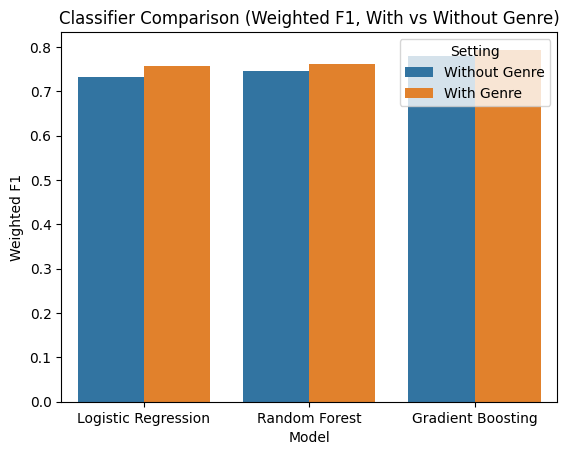

In [37]:
sns.barplot(data=results_df, x="Model", y="Weighted F1", hue="Setting")
plt.title("Classifier Comparison (Weighted F1, With vs Without Genre)")
plt.show()

From the performance metrics, comparison table, and visualization above, we observe a consistent pattern across all the classifiers, **the models with genres have a higher weighed precision, weighted recall, and the weighted F1 score**. 

For Logistic Regression, the weighted F1 score increases by approximately 2.5%, while Random Forest and Gradient Boosting each show an improvement of about 1.5%. From the prediction result of the voting classifiers with the best-tuned parameters for each model, **the prediction accuracy has increased from 77.78% to 78.70%**, indicating that genres do contribute to predicting platform availability. 

However, the improvement is moderate. This is expected since genres are **not the only determinant factors** of the platforms' preference. Other features such as score, rating, revenue, and release year also play an important role. Additionally, our data is not evenly distributed. The number of Netflix movies is much higher than that of the movies on the other two platforms, which may also have an impact on the accuracy of the predictions. 

Even so, our result above still confirms that genre of movie is a meaningful feature to platform classification, and we can answer our question that **streaming platforms do show specific preferences in the genres of movies they make available**. 